In [5]:
#Data path
restaurant_data_path = 'C:/Users/Aditya/Documents/GitHub/neu/nlp/LDA_Explore/output/restaurants.json'
restaurant_reviews_data_path = 'output/restaurant_reviews.json'


In [17]:
# load restaurant data into a data frame
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline

def load_restaurants_into_df(filename,keys):
    list_of_restaurants = []
    with open(restaurant_data_path,'r',encoding='utf-8') as f:
        for line in f:
            row = json.loads(line)
            row_dict = {}
            for key in keys:
                row_dict[key] = row[key]
            
            list_of_restaurants.append(row_dict)
    
    return pd.DataFrame(list_of_restaurants)

restaurants_df = load_restaurants_into_df(restaurant_data_path,['business_id','stars','state'])

    

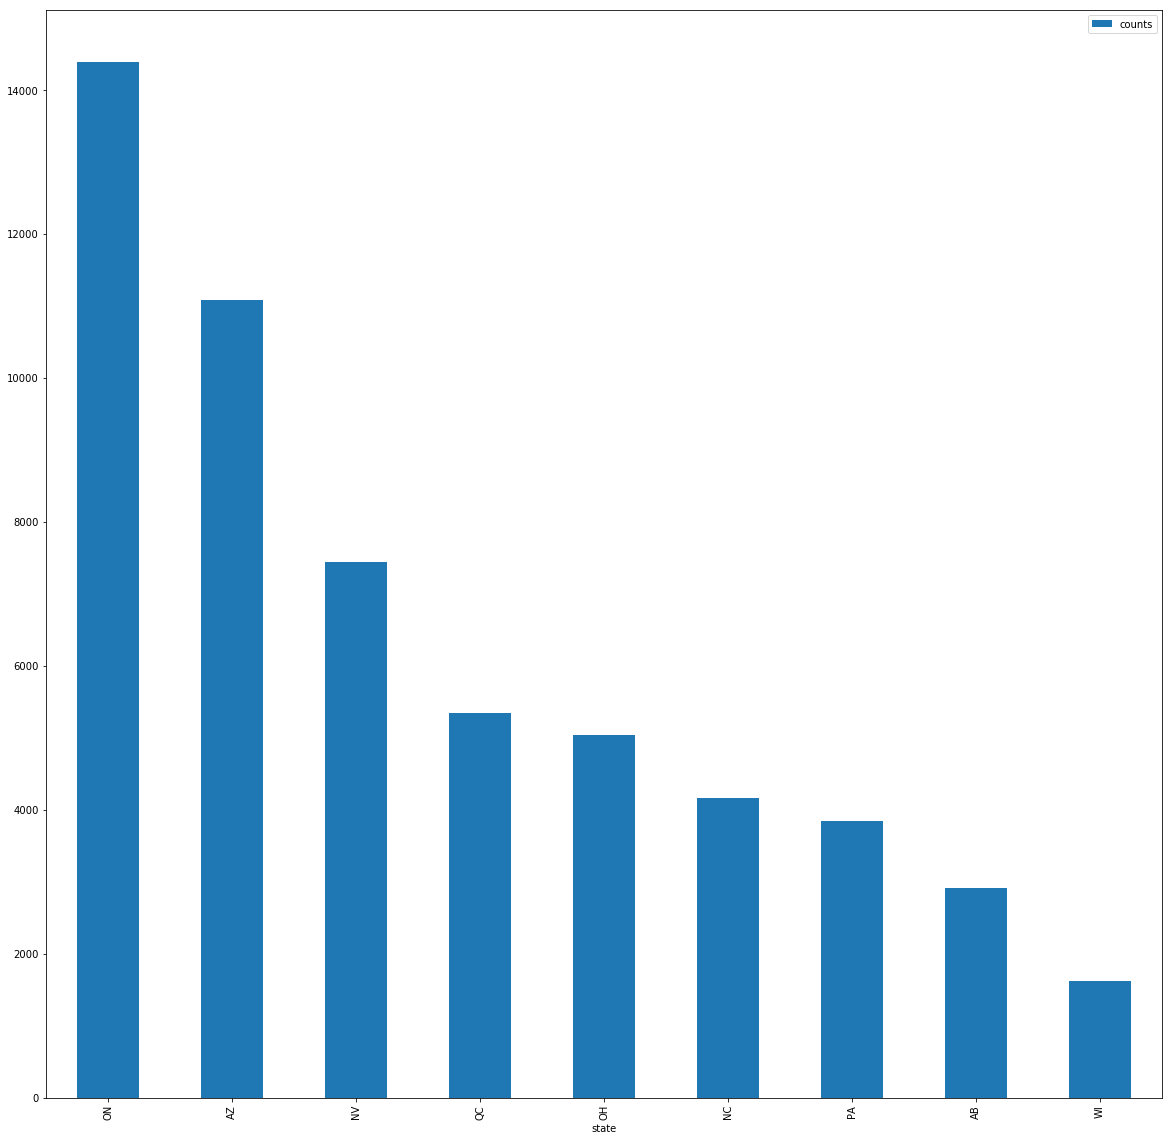

In [42]:
grouped = restaurants_df.groupby('state').size().reset_index(name='counts')
grouped_by_count_gt_1000 = grouped[grouped.counts > 1000].sort_values(by='counts',ascending = False)
grouped_by_count_gt_1000.plot.bar(x='state', y='counts',figsize=(20,20),fontsize=(10))


In [ ]:
# Based on above grave we will pick one of states with higher restaurants in United states - say NV

In [54]:
state_code = 'NV'
state_restaurants = restaurants_df[restaurants_df.state == state_code]
restaurant_ids = set(state_restaurants.business_id.values)

def load_user_reviews_by_business(filename,restaurant_ids):
    reviews = []
    with open(filename,'r',encoding='utf-8') as f:
        for line in f:
            row = json.loads(line)
            business_id = row['business_id']
            if business_id in restaurant_ids:
                reviews.append(row)
    
    return pd.DataFrame(reviews)

state_restaurant_reviews_df = load_user_reviews_by_business(restaurant_reviews_data_path,restaurant_ids)
state_restaurant_reviews_df.shape


(124849, 4)

In [57]:
state_restaurant_reviews_df['review_length'] = state_restaurant_reviews_df.text.map(len)
star1_df = state_restaurant_reviews_df[state_restaurant_reviews_df.stars == 1]
star1_df.shape

(21694, 5)

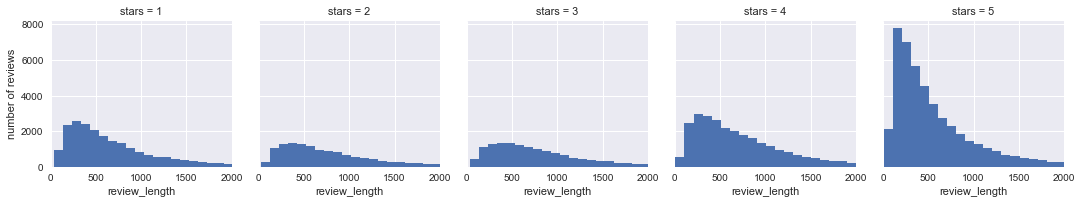

In [59]:
import seaborn as sns
sns.set()
ax = sns.FacetGrid(data=state_restaurant_reviews_df, col='stars', xlim=(0, 2000)).map(plt.hist, 'review_length', bins=50)
ax.axes[0][0].set(ylabel='number of reviews');

In [61]:
pos_reviews = state_restaurant_reviews_df.text[state_restaurant_reviews_df.stars>3].values
neg_reviews = state_restaurant_reviews_df.text[state_restaurant_reviews_df.stars<3].values
print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))


Postive Reviews:  74,653
Negative Reviews:  35,419


In [72]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_pos = TfidfVectorizer(stop_words='english', min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words='english', min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

neg_vectors = tfidf_neg.fit_transform(neg_reviews)
pos_vectors = tfidf_pos.fit_transform(pos_reviews)

Wall time: 12 s


In [200]:
%%time
# negative values in LSA topics are annoying
# let's see if we can fix that with NMF
from sklearn.decomposition import NMF

# change num_topics  start with 6 then go to 7 8 9 10 and 15 , you can see that 9 gives the best MSE ,RMSE and pearson
num_topics = 9 

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

Wall time: 22.1 s


In [201]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

no_topics = num_topics
no_top_words = 8

print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   1.002*just, 0.921*time, 0.886*like, 0.802*dinner, 0.782*ordered, 0.780*restaurant, 0.779*steak, 0.767*came
Topic 1:   4.062*pizza, 0.604*crust, 0.339*cheese, 0.309*pepperoni, 0.304*slice, 0.292*toppings, 0.260*pizzas, 0.235*garlic
Topic 2:   3.602*great, 1.564*service, 0.510*excellent, 0.500*atmosphere, 0.435*awesome, 0.365*friendly, 0.361*customer, 0.284*definitely
Topic 3:   3.613*sushi, 0.920*rolls, 0.903*roll, 0.611*ayce, 0.550*fish, 0.502*fresh, 0.410*eat, 0.361*sashimi
Topic 4:   2.082*chicken, 1.081*rice, 1.049*fried, 1.033*thai, 0.701*spicy, 0.654*sauce, 0.642*soup, 0.601*curry
Topic 5:   3.035*burger, 1.562*fries, 0.912*burgers, 0.481*cheese, 0.299*bacon, 0.288*shake, 0.253*onion, 0.252*truffle
Topic 6:   2.273*place, 1.655*love, 1.304*best, 1.093*vegas, 1.070*amazing, 0.831*staff, 0.777*friendly, 0.679*ve
Topic 7:   3.318*good, 1.443*really, 0.605*nice, 0.599*pretty, 0.562*place, 0.379*

In [202]:
print('Topic weights : ', W_pos[0])
print('Sum of weights: ', W_pos[0].sum())

Topic weights :  [ 0.00285022  0.          0.00191869  0.00371702  0.05214467  0.
  0.01902846  0.00977898]
Sum of weights:  0.0894380445035


In [203]:
from sklearn.preprocessing import normalize
print('Normalized Topic weights : ', normalize(W_pos[0].reshape(1,-1), norm='l1'))
print('Sum of normalized weights: ', normalize(W_pos[0].reshape(1,-1), norm='l1').sum())

Normalized Topic weights :  [[ 0.03186813  0.          0.02145278  0.04155971  0.58302565  0.
   0.21275575  0.10933799]]
Sum of normalized weights:  1.0


In [204]:
state_restaurant_pos_reviews_df = state_restaurant_reviews_df[['business_id', 'stars', 'text', 'review_length']][state_restaurant_reviews_df.stars>3].reset_index()
state_restaurant_neg_reviews_df = state_restaurant_reviews_df[['business_id', 'stars', 'text', 'review_length']][state_restaurant_reviews_df.stars<3].reset_index()
state_restaurant_pos_reviews_df.drop(labels='index', axis=1, inplace=True)
state_restaurant_neg_reviews_df.drop(labels='index', axis=1, inplace=True)
print(state_restaurant_pos_reviews_df.shape)
print(state_restaurant_neg_reviews_df.shape)

(74653, 4)
(35419, 4)


In [205]:
state_restaurant_pos_reviews_cm = pd.concat([state_restaurant_pos_reviews_df, pd.DataFrame(normalize(W_pos, norm='l1'))], axis=1)
state_restaurant_neg_reviews_cm = pd.concat([state_restaurant_neg_reviews_df, pd.DataFrame(normalize(W_neg, norm='l1'))], axis=1)


In [206]:
state_restaurant_pos_reviews_cm.drop(labels='text', axis=1, inplace=True)
state_restaurant_pos_reviews_cm.drop(labels='review_length', axis=1, inplace=True)
state_restaurant_neg_reviews_cm.drop(labels='text', axis=1, inplace=True)
state_restaurant_neg_reviews_cm.drop(labels='review_length', axis=1, inplace=True)

In [207]:
agg_topic_vector_columns = {x:'mean' for x in range(num_topics)}
agg_topic_vector_columns['stars'] = 'mean'

df_pos_bsns = state_restaurant_pos_reviews_cm.groupby('business_id').agg(agg_topic_vector_columns).reset_index()
df_neg_bsns = state_restaurant_neg_reviews_cm.groupby('business_id').agg(agg_topic_vector_columns).reset_index()

In [208]:
df_pos_bsns.head()

,business_id,0,1,2,3,4,5,6,7,stars
0,--9e1ONYQuAa-CB_Rrw7Tw,0.494666,0.008486,0.145863,0.007092,0.050992,0.024440,0.138324,0.130137,4.689076
1,--FBCX-N37CMYDfs790Bnw,0.232429,0.004163,0.389609,0.029511,0.061384,0.070311,0.143232,0.069361,4.250000
2,--q7kSBRb0vWC8lSkXFByA,0.000000,0.426561,0.075706,0.006772,0.007249,0.262453,0.084608,0.136651,4.500000
3,-1m9o3vGRA8IBPNvNqKLmA,0.533846,0.045358,0.121590,0.011446,0.026010,0.061876,0.170096,0.029777,5.000000
4,-1vfRrlnNnNJ5boOVghMPA,0.084650,0.006445,0.174091,0.554091,0.070420,0.003999,0.080541,0.025764,5.000000


In [209]:
df_neg_bsns.head()

,business_id,0,1,2,3,4,5,6,7,stars
0,--9e1ONYQuAa-CB_Rrw7Tw,0.234611,0.245708,0.001488,0.308675,0.042320,0.060003,0.106425,0.000770,1.777778
1,--FBCX-N37CMYDfs790Bnw,0.131475,0.356251,0.008075,0.101219,0.107200,0.044927,0.244960,0.005893,1.333333
2,-153AjTW5luZPK4omEujWA,0.000000,0.292534,0.114339,0.376366,0.031972,0.177067,0.000000,0.007721,2.000000
3,-1vfRrlnNnNJ5boOVghMPA,0.073833,0.015793,0.001896,0.280316,0.094912,0.000000,0.058364,0.474886,1.666667
4,-3zffZUHoY8bQjGfPSoBKQ,0.164169,0.373532,0.000310,0.238266,0.074053,0.011893,0.096293,0.041485,1.700000


In [210]:
merged_business_topic_df = pd.merge(df_pos_bsns, df_neg_bsns, on='business_id', how='outer',suffixes=('_pos', '_neg'))
merged_business_topic_df.head()

,business_id,0_pos,1_pos,2_pos,3_pos,4_pos,5_pos,6_pos,7_pos,stars_pos,0_neg,1_neg,2_neg,3_neg,4_neg,5_neg,6_neg,7_neg,stars_neg
0,--9e1ONYQuAa-CB_Rrw7Tw,0.494666,0.008486,0.145863,0.007092,0.050992,0.024440,0.138324,0.130137,4.689076,0.234611,0.245708,0.001488,0.308675,0.042320,0.060003,0.106425,0.000770,1.777778
1,--FBCX-N37CMYDfs790Bnw,0.232429,0.004163,0.389609,0.029511,0.061384,0.070311,0.143232,0.069361,4.250000,0.131475,0.356251,0.008075,0.101219,0.107200,0.044927,0.244960,0.005893,1.333333
2,--q7kSBRb0vWC8lSkXFByA,0.000000,0.426561,0.075706,0.006772,0.007249,0.262453,0.084608,0.136651,4.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1m9o3vGRA8IBPNvNqKLmA,0.533846,0.045358,0.121590,0.011446,0.026010,0.061876,0.170096,0.029777,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1vfRrlnNnNJ5boOVghMPA,0.084650,0.006445,0.174091,0.554091,0.070420,0.003999,0.080541,0.025764,5.000000,0.073833,0.015793,0.001896,0.280316,0.094912,0.000000,0.058364,0.474886,1.666667


In [211]:
merged_business_topic_df = merged_business_topic_df.fillna(0)
merged_business_topic_df = pd.merge(merged_business_topic_df,restaurants_df,on='business_id',how='inner')
merged_business_topic_df.head()

,business_id,0_pos,1_pos,2_pos,3_pos,4_pos,5_pos,6_pos,7_pos,stars_pos,...,1_neg,2_neg,3_neg,4_neg,5_neg,6_neg,7_neg,stars_neg,stars,state
0,--9e1ONYQuAa-CB_Rrw7Tw,0.494666,0.008486,0.145863,0.007092,0.050992,0.024440,0.138324,0.130137,4.689076,...,0.245708,0.001488,0.308675,0.042320,0.060003,0.106425,0.000770,1.777778,4.0,NV
1,--FBCX-N37CMYDfs790Bnw,0.232429,0.004163,0.389609,0.029511,0.061384,0.070311,0.143232,0.069361,4.250000,...,0.356251,0.008075,0.101219,0.107200,0.044927,0.244960,0.005893,1.333333,4.0,NV
2,--q7kSBRb0vWC8lSkXFByA,0.000000,0.426561,0.075706,0.006772,0.007249,0.262453,0.084608,0.136651,4.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.0,NV
3,-1m9o3vGRA8IBPNvNqKLmA,0.533846,0.045358,0.121590,0.011446,0.026010,0.061876,0.170096,0.029777,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.5,NV
4,-1vfRrlnNnNJ5boOVghMPA,0.084650,0.006445,0.174091,0.554091,0.070420,0.003999,0.080541,0.025764,5.000000,...,0.015793,0.001896,0.280316,0.094912,0.000000,0.058364,0.474886,1.666667,3.0,NV


In [212]:
pos_feature_names = [str(x)+'_pos' for x in range(num_topics)]
neg_feature_names = [str(x)+'_neg' for x in range(num_topics)]
feature_cols = pos_feature_names + neg_feature_names
X = merged_business_topic_df.loc[:, feature_cols]
X.shape
Y = merged_business_topic_df.loc[:, ['stars']].values.ravel()
Y.shape

(6375,)

In [213]:
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from math import sqrt

from sklearn.svm import SVR

def run_supervised(X_Train,Y_Train,X_Test,Y_Test):

    model = SVR(gamma='scale', C=1.0, epsilon=0.2)
    model.fit(X_Train,Y_Train)
    Y_Pred = model.predict(X_Test)
    MSE = mean_squared_error(Y_Test,Y_Pred)
    print(MSE)
    Pearsons_coefficient,p_value = pearsonr(Y_Test,Y_Pred)
    print("MSE " + str(MSE),"Pearsons " + str(Pearsons_coefficient))
    print("RMSE"+ str(sqrt(MSE)))

X_Train = X[:5000]
Y_Train = Y[:5000]

X_Test = X[5000:]
Y_Test = Y[5000:]

run_supervised(X_Train,Y_Train,X_Test,Y_Test)

1.03680952689
MSE 1.03680952689 Pearsons 0.429110481346
RMSE1.0182384430429827
